## Predicción de la próxima palabra

El objetivo de este notebook es entrenar un modelo de lenguaje basado en arquitecturas recurrentes a partir de un corpus.

La fuente de datos a utilizar es un dataset consistente en opiniones de clientes sobre un restaurante. El mismo puede hallarse el el siguiente link: [Kaggle - Restaurant reviews](https://www.kaggle.com/datasets/d4rklucif3r/restaurant-reviews)

En el transcurso del ejercicio se explorarán técnicas de generación de secuencias y se medirá la calidad de las mismas calculando la *perplejidad*.
Una vez entrenado el modelo, se lo empleará para generar las siguientes $\mathit{n}$ palabras, dada una secuencia de inicio.

### Librerías

In [1]:
import re
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from matplotlib import pyplot as plt
import seaborn as sns

### Carga de datos y preprocesamiento

In [2]:
!gdown 1DvubbEnZ8tvEYljksQCh7A9GGFgNi8wk

Downloading...
From: https://drive.google.com/uc?id=1DvubbEnZ8tvEYljksQCh7A9GGFgNi8wk
To: /content/Restaurant_Reviews.tsv
100% 61.3k/61.3k [00:00<00:00, 37.8MB/s]


In [3]:
df = pd.read_csv('Restaurant_Reviews.tsv', sep='\t')

print('\nCantidad de documentos:', df.shape[0])

df.drop(['Liked'], axis=1, inplace=True)
df.head()



Cantidad de documentos: 1000


,Review
0,Wow... Loved this place.
1,Crust is not good.
2,Not tasty and the texture was just nasty.
3,Stopped by during the late May bank holiday of...
4,The selection on the menu was great and so wer...


In [4]:
# Guardar cada oración en una lista.
text = list(df.loc[:, 'Review'])
text[:10]

['Wow... Loved this place.',
 'Crust is not good.',
 'Not tasty and the texture was just nasty.',
 'Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.',
 'The selection on the menu was great and so were the prices.',
 'Now I am getting angry and I want my damn pho.',
 "Honeslty it didn't taste THAT fresh.)",
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.',
 'The fries were great too.',
 'A great touch.']

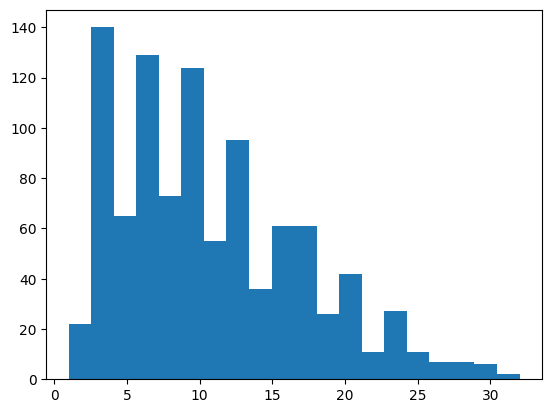

In [5]:
# Segmentar el texto.
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# Obtener las longitudes de cada oración.
length_sentences = [len(sentence) for sentence in segmented_sentences]

# Graficar un histograma con las longitudes.
plt.hist(length_sentences, bins=20)
plt.show()

In [6]:
segmented_sentences[:10]

[['wow', 'loved', 'this', 'place'],
 ['crust', 'is', 'not', 'good'],
 ['not', 'tasty', 'and', 'the', 'texture', 'was', 'just', 'nasty'],
 ['stopped',
  'by',
  'during',
  'the',
  'late',
  'may',
  'bank',
  'holiday',
  'off',
  'rick',
  'steve',
  'recommendation',
  'and',
  'loved',
  'it'],
 ['the',
  'selection',
  'on',
  'the',
  'menu',
  'was',
  'great',
  'and',
  'so',
  'were',
  'the',
  'prices'],
 ['now',
  'i',
  'am',
  'getting',
  'angry',
  'and',
  'i',
  'want',
  'my',
  'damn',
  'pho'],
 ['honeslty', 'it', "didn't", 'taste', 'that', 'fresh'],
 ['the',
  'potatoes',
  'were',
  'like',
  'rubber',
  'and',
  'you',
  'could',
  'tell',
  'they',
  'had',
  'been',
  'made',
  'up',
  'ahead',
  'of',
  'time',
  'being',
  'kept',
  'under',
  'a',
  'warmer'],
 ['the', 'fries', 'were', 'great', 'too'],
 ['a', 'great', 'touch']]

In [7]:
max_context_size = int(np.percentile(length_sentences, 90) - 1)
print(f'max_context_size: {max_context_size}')

max_context_size: 19


### Tokenizar

In [8]:
tok = Tokenizer()
tok.fit_on_texts(segmented_sentences)

# Convertir palabras tokenizadas a números.
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)
tokenized_sentences[:5]

[[428, 165, 8, 15],
 [586, 7, 12, 16],
 [12, 151, 2, 1, 429, 4, 46, 430],
 [587, 73, 292, 1, 588, 293, 898, 899, 180, 900, 901, 431, 2, 165, 9],
 [1, 166, 35, 1, 109, 4, 22, 2, 26, 27, 1, 167]]

### Dividir el dataset. Preprocesar generando secuencias de igual tamaño

In [9]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(
    tokenized_sentences,
    tokenized_sentences,
    test_size=0.2,
    random_state=42)

tok_sent = []
for sent in tokenized_sentences_train:
  # Si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armar varias sub-secuencias de tamaño máximo.
  if len(sent) > (max_context_size + 1):
    extra = len(sent)-(max_context_size + 1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i + max_context_size + 1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejar la secuencia como está
    tok_sent.append(sent)

print('Oraciones tokenizadas', len(tok_sent))

tok_sent_augm = []
for sent in tok_sent:
  # Generamos todas las sub-secuencias.
  subseq = [sent[:i+2] for i in range(len(sent) - 1)]
  # Agregar padding al tamaño de contexto máximo.
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size + 1, padding='pre'))

# Concatenar todas las secuencias en un único array de numpy.
train_seqs = np.concatenate(tok_sent_augm, axis=0)
print('Shape de secuencias de entrenamiento', train_seqs.shape)

X = train_seqs[:, :-1]
y = train_seqs[:, 1:]

Oraciones tokenizadas 1096
Shape de secuencias de entrenamiento (13306, 20)


### Palabras del vocabulario

In [10]:
tok.index_word

{1: 'the',
 2: 'and',
 3: 'i',
 4: 'was',
 5: 'a',
 6: 'to',
 7: 'is',
 8: 'this',
 9: 'it',
 10: 'of',
 11: 'food',
 12: 'not',
 13: 'for',
 14: 'in',
 15: 'place',
 16: 'good',
 17: 'service',
 18: 'we',
 19: 'very',
 20: 'my',
 21: 'with',
 22: 'great',
 23: 'had',
 24: 'that',
 25: 'be',
 26: 'so',
 27: 'were',
 28: 'are',
 29: 'but',
 30: 'have',
 31: 'back',
 32: 'you',
 33: 'here',
 34: 'they',
 35: 'on',
 36: 'at',
 37: 'like',
 38: 'go',
 39: 'all',
 40: 'time',
 41: 'our',
 42: 'will',
 43: 'there',
 44: 'as',
 45: 'really',
 46: 'just',
 47: 'an',
 48: 'their',
 49: 'if',
 50: 'best',
 51: 'would',
 52: 'ever',
 53: 'also',
 54: 'friendly',
 55: 'up',
 56: 'only',
 57: 'never',
 58: 'one',
 59: 'no',
 60: 'your',
 61: 'restaurant',
 62: 'out',
 63: 'nice',
 64: "don't",
 65: 'been',
 66: 'what',
 67: 'amazing',
 68: 'again',
 69: 'from',
 70: 'delicious',
 71: 'vegas',
 72: 'did',
 73: 'by',
 74: 'which',
 75: 'pretty',
 76: 'some',
 77: 'me',
 78: 'came',
 79: 'when',
 80: 

### Cantidad de palabras en vocabulario. Índice de cada una

In [11]:
vocab_size = len(tok.word_counts)
print('Cantidad de palabras en vocabulario', vocab_size)
print('Índices', tok.word_index)

Cantidad de palabras en vocabulario 2071
Índices {'the': 1, 'and': 2, 'i': 3, 'was': 4, 'a': 5, 'to': 6, 'is': 7, 'this': 8, 'it': 9, 'of': 10, 'food': 11, 'not': 12, 'for': 13, 'in': 14, 'place': 15, 'good': 16, 'service': 17, 'we': 18, 'very': 19, 'my': 20, 'with': 21, 'great': 22, 'had': 23, 'that': 24, 'be': 25, 'so': 26, 'were': 27, 'are': 28, 'but': 29, 'have': 30, 'back': 31, 'you': 32, 'here': 33, 'they': 34, 'on': 35, 'at': 36, 'like': 37, 'go': 38, 'all': 39, 'time': 40, 'our': 41, 'will': 42, 'there': 43, 'as': 44, 'really': 45, 'just': 46, 'an': 47, 'their': 48, 'if': 49, 'best': 50, 'would': 51, 'ever': 52, 'also': 53, 'friendly': 54, 'up': 55, 'only': 56, 'never': 57, 'one': 58, 'no': 59, 'your': 60, 'restaurant': 61, 'out': 62, 'nice': 63, "don't": 64, 'been': 65, 'what': 66, 'amazing': 67, 'again': 68, 'from': 69, 'delicious': 70, 'vegas': 71, 'did': 72, 'by': 73, 'which': 74, 'pretty': 75, 'some': 76, 'me': 77, 'came': 78, 'when': 79, "i've": 80, 'experience': 81, "i'm

### Definir el modelo

In [12]:
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=50, input_shape=(None,)),
    LSTM(200, return_sequences=True),
    Dropout(0.4),
    LSTM(200, return_sequences=True),
    Dropout(0.4),
    LSTM(100, return_sequences=True),
    Dropout(0.4),
    Dense(vocab_size + 1, activation='softmax')
])
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          103600    
                                                                 
 lstm (LSTM)                 (None, None, 200)         200800    
                                                                 
 dropout (Dropout)           (None, None, 200)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 200)         320800    
                                                                 
 dropout_1 (Dropout)         (None, None, 200)         0         
                                                                 
 lstm_2 (LSTM)               (None, None, 100)         120400    
                                                                 
 dropout_2 (Dropout)         (None, None, 100)         0

### Definir como callback a la métrica perplexity

In [13]:
class PplCallback(keras.callbacks.Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = history_ppl
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq) != 0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded, verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if self.patience is not None:
            if current_score < self.min_score:
                self.min_score = current_score
                self.model.save('my_model')
                print('Saved new model!')
                self.patience_counter = 0
            else:
                self.patience_counter += 1
                if self.patience_counter == self.patience:
                    print('Stopping training...')
                    self.model.stop_training = True


### Entrenamiento

In [14]:
history_ppl = []
hist = model.fit(
    X,
    y,
    epochs=30,
    callbacks=[PplCallback(tokenized_sentences_val, history_ppl, patience=6)],
    batch_size=32)

Epoch 1/30
416/416 [==============================] - ETA: 0s - loss: 3.8344
 mean perplexity: 1747.8946690800094 

Saved new model!
416/416 [==============================] - 86s 191ms/step - loss: 3.8344
Epoch 2/30
416/416 [==============================] - ETA: 0s - loss: 3.4439
 mean perplexity: 1588.9664077280968 

Saved new model!
416/416 [==============================] - 81s 194ms/step - loss: 3.4439
Epoch 3/30
416/416 [==============================] - ETA: 0s - loss: 3.2942
 mean perplexity: 1381.6732687790488 

Saved new model!
416/416 [==============================] - 81s 194ms/step - loss: 3.2942
Epoch 4/30
416/416 [==============================] - ETA: 0s - loss: 3.0425
 mean perplexity: 891.7631361976461 

Saved new model!
416/416 [==============================] - 80s 193ms/step - loss: 3.0425
Epoch 5/30
416/416 [==============================] - ETA: 0s - loss: 2.9992
 mean perplexity: 912.1600595320997 

416/416 [==============================] - 68s 163ms/step - lo

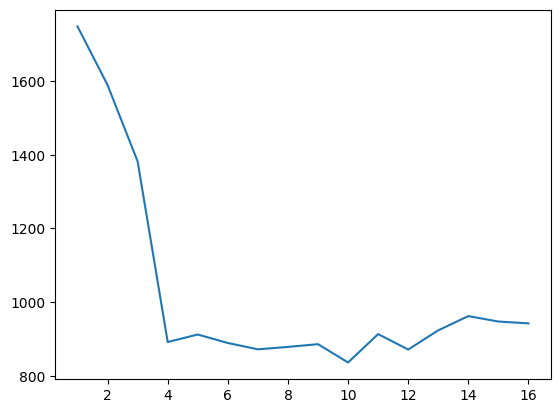

In [15]:
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count, y=history_ppl)
plt.show()

In [16]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model')

### Generación de secuencias

In [17]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    '''
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    '''
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0, -1, :])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [18]:
input_text = 'I was shocked because no signs'
generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 [==============================] - 0s 29ms/step


'I was shocked because no signs the and and and and and and and and and'

No obstante el entrenamiento converge y muestra un descenso de la métrica *perplexity*, el modelo no es lo suficientemente robusto frente a la tarea y con este dataset en particular.

### Beam search y muestreo aleatorio

In [19]:
# Funciones para hacer encoding y decoding.

def encode(text, max_length=max_context_size):
    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [20]:
from scipy.special import softmax

# Función que selecciona candidatos para el beam search
def select_candidates(pred, num_beams, vocab_size, history_probs, history_tokens, temp, mode):
  # Colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx, pp in enumerate(pred):
    pred_large.extend(np.log(pp + 1E-10) + history_probs[idx])

  pred_large = np.array(pred_large)

  # Criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large / temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # Traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # Devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)

def beam_search(model, num_beams, num_words, input, temp=1, mode='det'):
    # Encode
    encoded = encode(input)

    # First prediction
    y_hat = model.predict(encoded, verbose=0)[0,-1,:]

    # Get vocabulary size
    vocab_size = y_hat.shape[0]

    # Initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # Select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # Beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [21]:
# Predicciones con beam search estocástico usando diferentes parámetros de temperatura

salidas = beam_search(model, num_beams=10, num_words=6, input='despite having', temp=1, mode='sto')
print('Temperatura 1')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=10, num_words=6, input='despite having', temp=.5, mode='sto')
print('Temperatura 0.5')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=10, num_words=6, input='despite having', temp=1.5, mode='sto')
print('Temperatura 1.5')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=10, num_words=6, input='the potatoes were', temp=1, mode='sto')
print('\nTemperatura 1')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=10, num_words=6, input='the potatoes were', temp=.5, mode='sto')
print('Temperatura 0.5')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=10, num_words=6, input='the potatoes were', temp=1.5, mode='sto')
print('Temperatura 1.5')
print(decode(salidas[0]))

Temperatura 1
['despite having']
Temperatura 0.5
['despite having place and and was a the']
Temperatura 1.5
['despite having at if to place since begin']

Temperatura 1
['the potatoes were has were the to a to']
Temperatura 0.5
['the potatoes were the the the the and the']
Temperatura 1.5
['the potatoes were buffet the to once bite two']


In [22]:
# Predicciones con beam search determinístico

salidas = beam_search(model, num_beams=6, num_words=6, input='the meal was', temp=None, mode='det')
print('Beams 6')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=5, num_words=10, input='the meal was', temp=None, mode='det')
print('Beams 10')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=20, num_words=6, input='the meal was', temp=None, mode='det')
print('Beams 20')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=6, num_words=6, input='delicious', temp=None, mode='det')
print('\nBeams 6')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=5, num_words=10, input='delicious', temp=None, mode='det')
print('Beams 10')
print(decode(salidas[0]))

salidas = beam_search(model, num_beams=20, num_words=6, input='delicious', temp=None, mode='det')
print('Beams 20')
print(decode(salidas[0]))

Beams 6
['the meal was the the the the and and']
Beams 10
['the meal was the the the the and and and and and and']
Beams 20
['the meal was the the the the and and']

Beams 6
['delicious the the the the and and']
Beams 10
['delicious the the the the and and and and and and']
Beams 20
['delicious']
